<h1>SI 370 Homework 6</h1>
Haley Johnson

Resources Used:
<ul>
    <li></li>
    <li></li>
</ul>

TO DO: SOME BACKGROUND ON OVERALL APPROACH

In [ ]:
# !pip install transformers

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import nltk 

from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

# import tesnsorflow as tf
# import torch
# from transformers import BertTokenizer, BertModel, BertForSequenceClassification

In [3]:
sns.set(context = 'notebook', style = 'darkgrid')

<h2>Load in Dataset</h2>

In [4]:
fake = pd.read_csv('Fake.csv', encoding = 'utf-8')
true = pd.read_csv('True.csv', encoding = 'utf-8')

In [5]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
true['label'] = 1
fake['label'] = 0
df = pd.concat([true, fake])
df = df.reset_index(drop = True)

<h2>Exploratory Data Analysis</h2>

There are no missing values in the dataset

In [8]:
for col in df.columns:
    print(f"Missing values in '{col}': {pd.isnull(df[col]).sum()}")

Missing values in 'title': 0
Missing values in 'text': 0
Missing values in 'subject': 0
Missing values in 'date': 0
Missing values in 'label': 0


However, there are 5305 duplicate rows. We'll remove duplicates from the dataframe, so there's only one entry per story.

In [9]:
counts = df.groupby(['title', 'text']).size().reset_index(name = 'count')
duplicates = counts[counts['count'] > 1]
duplicates.shape

(5305, 3)

In [10]:
duplicates

,title,text,count
9055,#AnyoneButHillary: NEW POLL Shows Bernie Suppo...,Hillary may find out she needs more than black...,2
9056,#Austin: Fights Break Out Between Police and S...,Commies carrying flags fought with the Austin ...,2
9057,#Berkeley CRAZY! RIOTERS CHASE And Beat People...,Is anyone else thinking what we re thinking ab...,2
9058,#Berkeley IRONY ALERT! ANARCHISTS LOOT STARBUC...,Smashing windows How progressive!Protests aga...,2
9060,#BlackLivesMatter Supporters Say No Connection...,THE COMMON THREAD IN ALL THIS IS HATE THE HA...,2
...,...,...,...
39093,“WOODY” KAINE One Of Six ARRESTED After Peacef...,Watch the local news report as they explain wh...,2
39094,“We are progressive”: Activist Defends $190K P...,Immigration advocate Roberto Hernandez joined ...,2
39100,“Would You Rather Do A Job You Hate And Not Pa...,"Filmmaker and patriot, Dennis Michael Lynch is...",2
39102,“YOU’RE HIRED!” Trump Pulls Unemployed Vet Fro...,"No matter which candidate you support, this mo...",2


In [11]:
df = df.drop_duplicates(['text', 'title'])

This classes in the dataset are roughly balanced — 54.2% of the articles are real and 45.8% are fake. 

In [12]:
df.label.value_counts() / df.shape[0]

1    0.542053
0    0.457947
Name: label, dtype: float64

However, it appears that the subjects are not evenly distributed across fake and real news sources. In fact, real news articles use completely different subject labels than fake news. 

In [13]:
pd.crosstab(df.label, df.subject)

subject,Government News,News,US_News,left-news,politics,politicsNews,worldnews
label,,,,,,,
0,532,9050,783,705,6838,0,0
1,0,0,0,0,0,11217,9980


/var/folders/49/3f_15lzd6b57lnzlk4m_9k440000gn/T/ipykernel_31342/3783124482.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  crosstab = crosstab / crosstab.astype(float).sum(axis = 1)[:, np.newaxis]


[Text(0.5, 1.0, 'Subjects by Fake/Real Status'),
 Text(0.5, 19.909374999999997, 'Subject'),
 Text(47.25, 0.5, 'Category')]

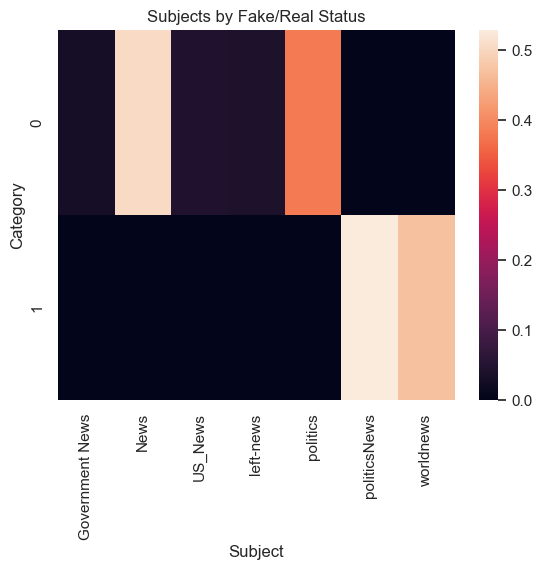

In [14]:
crosstab = pd.crosstab(df.label, df.subject)
crosstab = crosstab / crosstab.astype(float).sum(axis = 1)[:, np.newaxis]

f = sns.heatmap(crosstab)
f.set(title = 'Subjects by Fake/Real Status', xlabel = 'Subject', ylabel = 'Category')

<h2>Preprocess Text</h2>

To preprocess our text, we'll normalize it, remove punctuation, and remove URLS. Thankfully, the methods we use later in this notebook to transform text into machine readable inputs will remove stopwords for us. 

In [15]:
def clean_texts(df, punctuation = ['!', '?', '—', '/', '...', ",", "."]):
    '''
    Takes in dataframe and does basic text preprocessing
    Assumes that the text is in a column called "text"
    '''
    # make lower case 
    df.text = df.text.str.lower()
    
    # remove urls
    df.text = df.text.str.replace('http\S+', '', regex = True)

    # fix the quotations
    df.text = df.text.str.replace('”', '"', regex = True)
    df.text = df.text.str.replace('“', '"', regex = True)
    df.text = df.text.str.replace('“', '"', regex = True)
    df.text = df.text.str.replace('”', '"', regex = True)
    df.text = df.text.str.replace("‘", "'", regex = True)
    df.text = df.text.str.replace("’", "'", regex = True)
    df.text = df.text.str.replace("‘", "'", regex = True)
    df.text = df.text.str.replace("´", "'", regex = True)
    df.text = df.text.str.replace("`", "'", regex = True)
    
    # remove other punctuation 
    for p in punctuation: 
        df.text = df.text.str.replace(f'punc', '', regex = True)
      
    return df

In [16]:
# import string
# s = '... some string with punctuation ...'
# s = s.translate(None, string.punctuation)

TypeError: translate() takes exactly one argument (2 given)

IDEAS — People mentioned?

<h2>Split Text</h2>

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.label, random_state = 42)

<h2>Extra Trees Classifier</h2>
Used in conjunction with TFIDV preprocessing

In [19]:
tfidv = TfidfVectorizer(smooth_idf = False, sublinear_tf = False, norm = None, lowercase = True,
                     analyzer = 'word', stop_words = 'english')

X_train_tfidv = tfidv.fit_transform(X_train)
X_test_tfidv = tfidv.transform(X_test)

In [22]:
n_estimators = {'n_estimators': [50, 100, 150, 250, 500]}

extra_trees = ExtraTreesClassifier(random_state = 42)
extra_trees_clf = GridSearchCV(extra_trees, n_estimators, cv = 3, verbose = 3.1)

extra_trees_clf.fit(X_train_tfidv, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END ...................n_estimators=50;, score=0.968 total time=  53.6s
[CV 2/3] END ...................n_estimators=50;, score=0.969 total time= 1.1min
[CV 3/3] END ...................n_estimators=50;, score=0.975 total time=  54.1s
[CV 1/3] END ..................n_estimators=100;, score=0.971 total time= 2.0min
[CV 2/3] END ..................n_estimators=100;, score=0.970 total time= 1.8min
[CV 3/3] END ..................n_estimators=100;, score=0.975 total time= 1.8min
[CV 1/3] END ..................n_estimators=150;, score=0.973 total time= 2.7min
[CV 2/3] END ..................n_estimators=150;, score=0.971 total time= 2.8min
[CV 3/3] END ..................n_estimators=150;, score=0.974 total time= 2.5min
[CV 1/3] END ..................n_estimators=250;, score=0.974 total time= 5.0min
[CV 2/3] END ..................n_estimators=250;, score=0.972 total time= 4.4min
[CV 3/3] END ..................n_estimators=250;,

GridSearchCV(cv=3, estimator=ExtraTreesClassifier(random_state=42),
             param_grid={'n_estimators': [50, 100, 150, 250]}, verbose=3.1)

In [24]:
extra_trees_clf.best_params_, extra_trees_clf.best_score_

({'n_estimators': 250}, 0.9730973813420624)

In [25]:
extra_trees_clf.score(X_test_tfidv, y_test)

0.9728955712386212

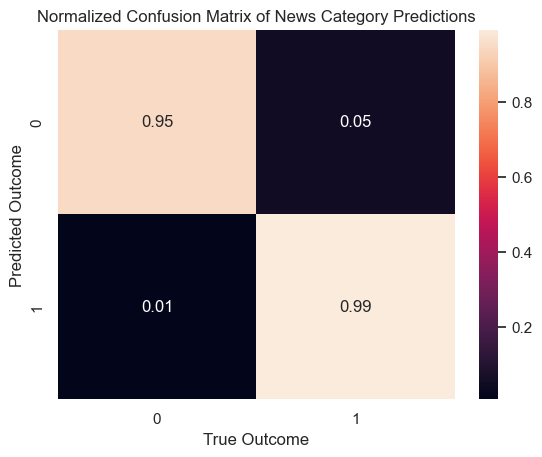

In [32]:
conf_matrix = confusion_matrix(y_test, extra_trees_clf.predict(X_test_tfidv))
normalized_conf_matrix = conf_matrix / conf_matrix.astype(float).sum(axis = 1)[:, np.newaxis]

f = sns.heatmap(normalized_conf_matrix, annot = True, fmt = '.2f')
_ = f.set(title = 'Normalized Confusion Matrix of News Category Predictions', ylabel = 'Predicted Outcome', xlabel = 'True Outcome')

<h2>Support Vector Classification</h2>

In [36]:
estimators = {'gamma': ['scale',  'auto']}
svc = SVC(kernel = 'linear', random_state = 42)

svc_model = GridSearchCV(svc, estimators, cv = 3, verbose = 3.1)
svc_model.fit(X_train_tfidv, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END .......................gamma=scale;, score=0.988 total time= 2.4min
[CV 2/3] END .......................gamma=scale;, score=0.988 total time= 2.2min
[CV 3/3] END .......................gamma=scale;, score=0.985 total time= 2.3min
[CV 1/3] END ........................gamma=auto;, score=0.988 total time= 2.7min
[CV 2/3] END ........................gamma=auto;, score=0.988 total time= 2.2min
[CV 3/3] END ........................gamma=auto;, score=0.985 total time= 2.4min


GridSearchCV(cv=3, estimator=SVC(kernel='linear', random_state=42),
             param_grid={'gamma': ['scale', 'auto']}, verbose=3.1)

In [37]:
svc_model.best_params_, extra_trees_clf.best_score_

({'gamma': 'scale'}, 0.9730973813420624)

In [38]:
svc_model.score(X_test_tfidv, y_train)

1.0

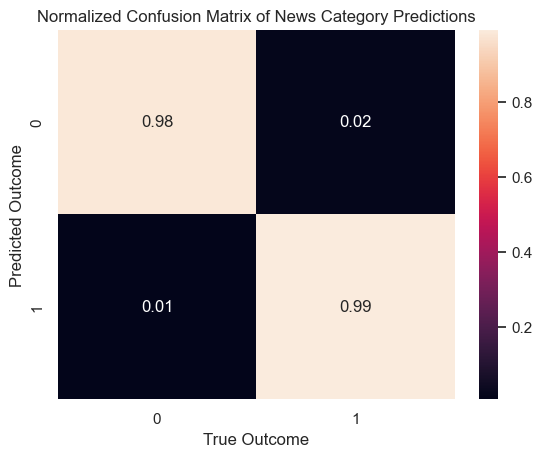

In [39]:
conf_matrix = confusion_matrix(y_test, svc_model.predict(X_test_tfidv))
normalized_conf_matrix = conf_matrix / conf_matrix.astype(float).sum(axis = 1)[:, np.newaxis]

f = sns.heatmap(normalized_conf_matrix, annot = True, fmt = '.2f')
_ = f.set(title = 'Normalized Confusion Matrix of News Category Predictions', ylabel = 'Predicted Outcome', xlabel = 'True Outcome')

<h2>BERT Deep Learning Classifier</h2>

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased", do_lower_case=True)
df['tokens'] = df.text.apply(lambda s: tokenizer.tokenize(s))